# Using Embeddings for unsupervised clustering with named clusters (and other fun things)

In this notebook, we use a subset of the [Top 10000 Popular Movies Dataset](https://www.kaggle.com/datasets/db55ac3dfd0098a0cf96dd542807f9253a16587ff233e06baef372bccfd09942) to calculate embeddings on movie descriptions and then apply kmeans to find similar clusters. Once we have these clusters, we'll use a prompt to extract the topics from each cluster. 

Fill out the missing pieces in the source source to get everything working (indicated by `#FIXME`).

In [10]:
import os
import tiktoken
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from openai.embeddings_utils import cosine_similarity
from tenacity import retry, wait_random_exponential, stop_after_attempt

# Load environment variables
load_dotenv('../.env')

# Configure Azure OpenAI Service API
openai.api_type = "azure"
openai.api_version = os.getenv('OPENAI_API_VERSION', "2022-12-01")
OPENAI_API_BASE = openai.api_base = os.getenv('OPENAI_API_BASE')
openai.api_key = os.getenv("OPENAI_API_KEY")

# Define embedding model and encoding
EMBEDDING_MODEL = os.getenv('OPENAI_EMBEDDING_MODEL', 'text-embedding-ada-002')
EMBEDDING_ENCODING = os.getenv('OPENAI_EMBEDDING_ENCODING', 'cl100k_base')
EMBEDDING_CHUNK_SIZE = os.getenv('OPENAI_EMBEDDING_CHUNK_SIZE', 8000)
COMPLETION_MODEL = os.getenv('OPENAI_COMPLETION_MODEL', 'gpt-35-turbo')

# initialize tiktoken for encoding text
encoding = tiktoken.get_encoding(EMBEDDING_ENCODING)

params_gathered = dict(
    EMBEDDING_MODEL=EMBEDDING_MODEL,
    EMBEDDING_ENCODING=EMBEDDING_ENCODING,
    EMBEDDING_CHUNK_SIZE=EMBEDDING_CHUNK_SIZE,
    COMPLETION_MODEL=COMPLETION_MODEL,
    OPENAI_API_VERSION=openai.api_version,
    OPENAI_API_BASE=OPENAI_API_BASE
)
for key, val in params_gathered.items():
    print(key, val)

EMBEDDING_MODEL text-embedding-ada-002
EMBEDDING_ENCODING cl100k_base
EMBEDDING_CHUNK_SIZE 8000
COMPLETION_MODEL gpt-35-turbo
OPENAI_API_VERSION 2022-12-01
OPENAI_API_BASE https://handsonoctober.openai.azure.com/


Load `movies.csv`:

In [11]:
df = pd.read_csv('../data/movies/movies.csv')
print(df.shape)
df

(500, 12)


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.
...,...,...,...,...,...,...,...,...,...,...,...,...
495,81796.0,en,Lockout,64.097,2012-04-12,5.9,1444.0,"['Action', 'Thriller', 'Science Fiction']","Set in the near future, Lockout follows a fals...",3.220403e+07,95.0,Take no prisoners.
496,284054.0,en,Black Panther,95.125,2018-02-13,7.4,18107.0,"['Action', 'Adventure', 'Science Fiction']","King T'Challa returns home to the reclusive, t...",1.346739e+09,134.0,Long live the king.
497,2114.0,en,Final Fantasy: The Spirits Within,18.627,2001-07-02,6.2,1128.0,"['Adventure', 'Action', 'Animation', 'Fantasy'...","Led by a strange dream, scientist Aki Ross str...",8.513183e+07,106.0,Unleash a new reality
498,85350.0,en,Boyhood,19.249,2014-06-05,7.5,4262.0,['Drama'],The film tells a story of a divorced couple tr...,4.813767e+07,165.0,12 years in the making.


Next, let's create a new column and calculate how many tokens each embedding would cost. This allows us to get an estimate how much we'd pay to create embeddings on the whole dataset.

In [12]:

def get_tokens(input_text):
    """Returns the number of tokens in a text by a given encoding."""
    tokens = encoding.encode(input_text)
    return tokens

df['token_count']=df['overview'].apply(lambda x: len(get_tokens(x)))
df.head()

# add a new column to the dataframe where you put the token count of the overview
#FIXME
# df['token_count'] = df['overview'].apply(lambda x: get_num_tokens(x, encoding_name='EMBEDDING_ENCODING'))

# print the first 5 rows of the dataframe, then also the total number of tokens
total_tokens = df['token_count'].sum()   #FIXME
print(total_tokens)

cost_for_embeddings = total_tokens / 1000 * 0.0004
print(f"Test would cost ${cost_for_embeddings} for embeddings")

29391
Test would cost $0.0117564 for embeddings


In [13]:
df.iloc[0]

id                                                            381284.0
original_language                                                   en
original_title                                          Hidden Figures
popularity                                                      49.802
release_date                                                2016-12-10
vote_average                                                       8.1
vote_count                                                      7310.0
genre                                             ['Drama', 'History']
overview             The untold story of Katherine G. Johnson, Doro...
revenue                                                    230698791.0
runtime                                                          127.0
tagline              Meet the women you don't know, behind the miss...
token_count                                                         62
Name: 0, dtype: object

Let's define our embedding method. Please note the use of tenacity for having an automated retry mechanism, in case we hit the TPS limits of Azure OpenAI Service.

In [14]:
from openai.embeddings_utils import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


import re

def normalize_text(string, sep_token = " \n "):
    """Normalize text by removing unnecessary characters and altering the format of words."""
    # make text lowercase
    string = re.sub(r'\s+',  ' ', string).strip()
    string = re.sub(r". ,","",string)
    # remove all instances of multiple spaces
    string = string.replace("..",".")
    string = string.replace("!!","!")
    string = string.replace(". .",".")
    string = string.replace("\n", "")
    string = string.strip()
    return string


@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text) -> list[float]:
    text = text.replace("\n", " ")
    embeddings = model.encode(text)
    # print(len(embeddings))
    return embeddings

    #return #FIXME

Let's creating the embeddings:

In [15]:
# df = #FIXME

# del df['overview_embedding']
df['embedding'] = df['overview'].apply(lambda x: get_embedding(x))
df.head()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.04648739, -0.013596974, -0.018194607, 0.09..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.07511196, 0.05680961, -0.032894667, 0.0163..."
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[0.06370305, 0.0003377361, -0.057780314, 0.016..."
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[0.03406623, 0.0416562, 0.026990961, 0.0238385..."
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.10075497, 0.045750607, -0.0045793317, -0.0..."


Next, let's create clusters on the embeddings using KMeans. In this case, we'll go for 5 clusters, knowing that this might be wrong.

In [16]:
# train k-means on df embeddings
from sklearn.cluster import KMeans

n_clusters = 5
#FIXME
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=0).fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head()

/workspaces/azure-openai-in-a-day-workshop/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding,cluster
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.04648739, -0.013596974, -0.018194607, 0.09...",2
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.07511196, 0.05680961, -0.032894667, 0.0163...",1
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[0.06370305, 0.0003377361, -0.057780314, 0.016...",1
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[0.03406623, 0.0416562, 0.026990961, 0.0238385...",2
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.10075497, 0.045750607, -0.0045793317, -0.0...",1


Now that we have a cluster per row, let's use t-SNE to project our embeddings into 2d space and visualize the clusters.

(500, 384)


/tmp/ipykernel_630/1841760733.py:20: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/workspaces/azure-openai-in-a-day-workshop/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_630/1841760733.py:21: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


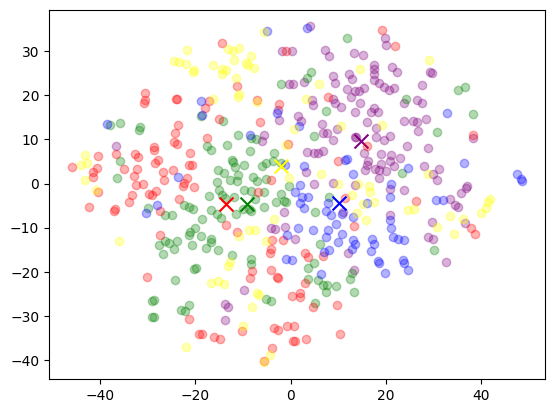

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

Ugh ok, that does not look great, but was somehow expected. We have all kinds of movies and with only 5 clusters, this might not be ideal. However, if you look closely, you can make up some rough shape that resembles a cluster. Also, movies might fall into two or more categories, so it kind of makes sense.

Lastly, let's take a few examples from each cluster, send them to Azure OpenAI Service and get the common theses extracted:

In [19]:
# take 10 movies from each cluster and write a prompt that asks what these have in common
# ideally you would use more movies than 10, but this is just a demo
for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['overview'].sample(10)
    reviews = "\n".join(reviews.values.tolist())

    prompt = f"Here are 10 movie descriptions:\n{reviews}Write 3 words what these have in common?" 
    # prompt = #FIXME write a prompt that find common topics in the reviews
    response = openai.Completion.create(engine=COMPLETION_MODEL, prompt=prompt, temperature=0.7, max_tokens=100, top_p=1, frequency_penalty=0, presence_penalty=0, stop=None)['choices'][0]['text'].strip()
    #response = #FIXME
    print(f"Cluster {i} topics: {response}")
    movies = df[df['cluster'] == i]['original_title'].sample(25)
    print(f"Movies from cluster {i}: {', '.join(movies.values.tolist())}")
    print("================")    

AuthenticationError: Access denied due to invalid subscription key or wrong API endpoint. Make sure to provide a valid key for an active subscription and use a correct regional API endpoint for your resource.

Doesn't look too bad. But again, 10 samples for each class might not be enough, given the low number of clusters. Anyway, looking at the movie titles, some of the topics actually make fairly ok sense.

# Bonus: Using the embeddings to build a simple recommendation system

Another thing we can do is use the embeddings for building a very simple recommendation system. So let's try it:

In [ ]:
movie = "Frozen"

# get embedding for movie
e = #FIXME

# get cosine similarity between movie and all other movies
similarities = #FIXME

# get most similar movies
movies = #FIXME
movies[1:6]

Besides the last one, this actually does not look too bad...probably would have been useful if we added movie categories and age ratings to our recommendations... :)